### Semantic search with nlp

In [5]:
# Load libraries

import pandas as pd
import numpy as np 
import string
import random

import nltk
from nltk.corpus import brown
from nltk.corpus import reuters

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

In [6]:
#load 10k reuters news documents 
nltk.download('reuters')
len(reuters.fileids())

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


10788

In [7]:
#view text from one document 
reuters.raw(fileids=['test/14826'])[0:201]

"ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT\n  Mounting trade friction between the\n  U.S. And Japan has raised fears among many of Asia's exporting\n  nations that the row could inflict far-reaching"

In [8]:
# remove punctuation from all DOCs 
exclude = set(string.punctuation)
alldocslist = []

for index, i in  enumerate(reuters.fileids()):
    text = reuters.raw(fileids=[i])
    text = ''.join(ch for ch in text if ch not in exclude)
    alldocslist.append(text)
    
print(alldocslist[1])

CHINA DAILY SAYS VERMIN EAT 712 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  showed vermin consume between seven and 12 pct of Chinas grain
  stocks the China Daily said
      It also said that each year 1575 mln tonnes or 25 pct of
  Chinas fruit output are left to rot and 21 mln tonnes or up
  to 30 pct of its vegetables The paper blamed the waste on
  inadequate storage and bad preservation methods
      It said the government had launched a national programme to
  reduce waste calling for improved technology in storage and
  preservation and greater production of additives The paper
  gave no further details
  




In [9]:
#tokenize words in all DOCS 
plot_data = [[]] * len(alldocslist)

for doc in alldocslist:
    text = doc
    tokentext = word_tokenize(text)
    plot_data[index].append(tokentext)
    
print(plot_data[0][1])

['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '712', 'PCT', 'GRAIN', 'STOCKS', 'A', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume', 'between', 'seven', 'and', '12', 'pct', 'of', 'Chinas', 'grain', 'stocks', 'the', 'China', 'Daily', 'said', 'It', 'also', 'said', 'that', 'each', 'year', '1575', 'mln', 'tonnes', 'or', '25', 'pct', 'of', 'Chinas', 'fruit', 'output', 'are', 'left', 'to', 'rot', 'and', '21', 'mln', 'tonnes', 'or', 'up', 'to', '30', 'pct', 'of', 'its', 'vegetables', 'The', 'paper', 'blamed', 'the', 'waste', 'on', 'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', 'It', 'said', 'the', 'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', 'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', 'and', 'greater', 'production', 'of', 'additives', 'The', 'paper', 'gave', 'no', 'further', 'details']


In [10]:
# Navigation: first index gives all documents, second index gives specific document, third index gives words of that doc
plot_data[0][1][0:10]

['CHINA',
 'DAILY',
 'SAYS',
 'VERMIN',
 'EAT',
 '712',
 'PCT',
 'GRAIN',
 'STOCKS',
 'A']

In [11]:
#make all words lower case for all docs 
for x in range(len(reuters.fileids())):
    lowers = [word.lower() for word in plot_data[0][x]]
    plot_data[0][x] = lowers

plot_data[0][1][0:10]

['china',
 'daily',
 'says',
 'vermin',
 'eat',
 '712',
 'pct',
 'grain',
 'stocks',
 'a']

In [12]:
# remove stop words from all docs 
stop_words = set(stopwords.words('english'))

for x in range(len(reuters.fileids())):
    filtered_sentence = [w for w in plot_data[0][x] if not w in stop_words]
    plot_data[0][x] = filtered_sentence

plot_data[0][1][0:10]

['china',
 'daily',
 'says',
 'vermin',
 'eat',
 '712',
 'pct',
 'grain',
 'stocks',
 'survey']

In [13]:
#stem words EXAMPLE (could try others/lemmers )

snowball_stemmer = SnowballStemmer("english")
stemmed_sentence = [snowball_stemmer.stem(w) for w in filtered_sentence]
stemmed_sentence[0:10]

porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer("english")
stemmed_sentence = [ porter_stemmer.stem(w) for w in filtered_sentence]
stemmed_sentence[0:10]

['ltaha',
 'automot',
 'technolog',
 'corp',
 'year',
 'net',
 'shr',
 '43',
 'ct',
 'vs']

In [14]:
# Create inverse index which gives document number for each document and where word appears

#first we need to create a list of all words 
l = plot_data[0]
flatten = [item for sublist in l for item in sublist]
words = flatten
wordsunique = set(words)
wordsunique = list(wordsunique)

In [15]:
# create functions for TD-IDF / BM25
import math
from textblob import TextBlob as tb

def tf(word, doc):
    return doc.count(word) / len(doc)

def n_containing(word, doclist):
    return sum(1 for doc in doclist if word in doc)

def idf(word, doclist):
    return math.log(len(doclist) / (0.01 + n_containing(word, doclist)))

def tfidf(word, doc, doclist):
    return (tf(word, doc) * idf(word, doclist))

In [16]:
# Create dictonary of words
# THIS ONE-TIME INDEXING IS THE MOST PROCESSOR-INTENSIVE STEP AND WILL TAKE TIME TO RUN (BUT ONLY NEEDS TO BE RUN ONCE)
import re
import numpy as np

plottest = plot_data[0][0:1000]

worddic = {}

for doc in plottest:
    for word in wordsunique:
        if word in doc:
            word = str(word)
            index = plottest.index(doc)
            positions = list(np.where(np.array(plottest[index]) == word)[0])
            idfs = tfidf(word,doc,plottest)
            try:
                worddic[word].append([index,positions,idfs])
            except:
                worddic[word] = []
                worddic[word].append([index,positions,idfs])

In [17]:
# the index creates a dic with each word as a KEY and a list of doc indexs, word positions, and td-idf score as VALUES
worddic['china']

[[1, [0, 23], 0.1131500878815288],
 [13, [0], 0.06694713532990454],
 [14, [160], 0.013213250394060107],
 [28, [51], 0.05821490028687352],
 [40, [3, 15, 59, 79], 0.14740653650621185],
 [236, [86], 0.04414096834938761],
 [281, [70], 0.0565750439407644],
 [293, [13, 21], 0.11642980057374704],
 [302, [33], 0.059952658504392124],
 [342, [55, 146], 0.05391715597039292],
 [567, [2], 0.06925565723783228],
 [569, [1014, 1072, 1221], 0.009248261212112677],
 [612, [20], 0.01998421950146404],
 [710, [0, 7, 34], 0.17464470086062053],
 [720, [0, 16], 0.23628400704672192],
 [721, [0, 6, 27, 78, 82], 0.2028701070603168],
 [733, [179], 0.021595850106420823],
 [736, [0, 5, 21, 83], 0.13732745708698368]]

In [18]:
# pickel (save) the dictonary to avoid re-calculating
np.save('worddic_1000.npy', worddic)

In [19]:
# create word search which takes multiple words and finds documents that contain both along with metrics for ranking:

    ## (1) Number of occruances of search words 
    ## (2) TD-IDF score for search words 
    ## (3) Percentage of search terms
    ## (4) Word ordering score 
    ## (5) Exact match bonus 


from collections import Counter

def search(searchsentence):
    try:
        # split sentence into individual words 
        searchsentence = searchsentence.lower()
        try:
            words = searchsentence.split(' ')
        except:
            words = list(words)
        enddic = {}
        idfdic = {}
        closedic = {}
        
        # remove words if not in worddic 
        realwords = []
        for word in words:
            if word in list(worddic.keys()):
                realwords.append(word)  
        words = realwords
        numwords = len(words)
        
        # make metric of number of occurances of all words in each doc & largest total IDF 
        for word in words:
            for indpos in worddic[word]:
                index = indpos[0]
                amount = len(indpos[1])
                idfscore = indpos[2]
                enddic[index] = amount
                idfdic[index] = idfscore
                fullcount_order = sorted(enddic.items(), key=lambda x:x[1], reverse=True)
                fullidf_order = sorted(idfdic.items(), key=lambda x:x[1], reverse=True)

                
        # make metric of what percentage of words appear in each doc
        combo = []
        alloptions = {k: worddic.get(k, None) for k in (words)}
        for worddex in list(alloptions.values()):
            for indexpos in worddex:
                for indexz in indexpos:
                    combo.append(indexz)
        comboindex = combo[::3]
        combocount = Counter(comboindex)
        for key in combocount:
            combocount[key] = combocount[key] / numwords
        combocount_order = sorted(combocount.items(), key=lambda x:x[1], reverse=True)
        
        # make metric for if words appear in same order as in search
        if len(words) > 1:
            x = []
            y = []
            for record in [worddic[z] for z in words]:
                for index in record:
                     x.append(index[0])
            for i in x:
                if x.count(i) > 1:
                    y.append(i)
            y = list(set(y))

            closedic = {}
            for wordbig in [worddic[x] for x in words]:
                for record in wordbig:
                    if record[0] in y:
                        index = record[0]
                        positions = record[1]
                        try:
                            closedic[index].append(positions)
                        except:
                            closedic[index] = []
                            closedic[index].append(positions)

            x = 0
            fdic = {}
            for index in y:
                csum = []
                for seqlist in closedic[index]:
                    while x > 0:
                        secondlist = seqlist
                        x = 0
                        sol = [1 for i in firstlist if i + 1 in secondlist]
                        csum.append(sol)
                        fsum = [item for sublist in csum for item in sublist]
                        fsum = sum(fsum)
                        fdic[index] = fsum
                        fdic_order = sorted(fdic.items(), key=lambda x:x[1], reverse=True)
                    while x == 0:
                        firstlist = seqlist
                        x = x + 1
        else:
            fdic_order = 0
                    
        # also the one above should be given a big boost if ALL found together 
           
        
        #could make another metric for if they are not next to each other but still close 
        
        
        return(searchsentence,words,fullcount_order,combocount_order,fullidf_order,fdic_order)
    
    except:
        return("")


search('indonesia crude palm oil')[1]

['indonesia', 'crude', 'palm', 'oil']

In [20]:
# 0 return will give back the search term, the rest will give back metrics (see above)

search('indonesia crude palm oil')[1][1:10]

['crude', 'palm', 'oil']

In [21]:
# save metrics to dataframe for use in ranking and machine learning 
result1 = search('china daily says what')
result2 = search('indonesia crude palm oil')
result3 = search('price of nickel')
result4 = search('north yemen sugar')
result5 = search('nippon steel')
result6 = search('China')
result7 = search('Gold')
result8 = search('trade')
df = pd.DataFrame([result1,result2,result3,result4,result5,result6,result7,result8])
df.columns = ['search term', 'actual_words_searched','num_occur','percentage_of_terms','td-idf','word_order']
df

,search term,actual_words_searched,num_occur,percentage_of_terms,td-idf,word_order
0,china daily says what,"[china, daily, says]","[(183, 5), (40, 4), (569, 3), (710, 3), (342, ...","[(1, 1.0), (13, 0.6666666666666666), (14, 0.66...","[(675, 0.5095658223243495), (135, 0.4367707048...","[(1, 3), (293, 1), (720, 1), (721, 1), (736, 0..."
1,indonesia crude palm oil,"[indonesia, crude, palm, oil]","[(33, 13), (621, 12), (34, 11), (209, 8), (123...","[(4, 1.0), (6, 1.0), (209, 0.5), (281, 0.5), (...","[(762, 0.48707909813666866), (266, 0.434203698...","[(34, 6), (4, 5), (660, 5), (6, 4), (268, 2), ..."
2,price of nickel,"[price, nickel]","[(572, 19), (639, 8), (108, 7), (148, 7), (736...","[(724, 1.0), (4, 0.5), (7, 0.5), (20, 0.5), (2...","[(50, 0.24460301234499893), (537, 0.2066299280...","[(724, 0)]"
3,north yemen sugar,"[north, yemen, sugar]","[(700, 12), (96, 8), (494, 7), (296, 6), (525,...","[(30, 1.0), (758, 1.0), (47, 0.666666666666666...","[(494, 0.3808351739278394), (30, 0.35115970582...","[(758, 2), (30, 2), (851, 0), (47, 0)]"
4,nippon steel,"[nippon, steel]","[(40, 9), (253, 8), (444, 7), (223, 2), (435, ...","[(40, 1.0), (123, 0.5), (223, 0.5), (253, 0.5)...","[(223, 0.5682589478261134), (40, 0.42228417223...","[(40, 5)]"
5,china,[china],"[(721, 5), (40, 4), (736, 4), (569, 3), (710, ...","[(1, 1.0), (13, 1.0), (14, 1.0), (28, 1.0), (4...","[(720, 0.23628400704672192), (721, 0.202870107...",0
6,gold,[gold],"[(997, 6), (20, 5), (797, 5), (341, 4), (347, ...","[(8, 1.0), (12, 1.0), (20, 1.0), (32, 1.0), (2...","[(304, 0.30902054113001826), (20, 0.2575171176...",0
7,trade,[trade],"[(0, 15), (169, 10), (544, 10), (761, 8), (273...","[(285, 2.0), (701, 2.0), (713, 2.0), (923, 2.0...","[(223, 0.24728127372797265), (449, 0.247281273...",0


In [22]:
# look to see if the top documents seem to make sense

alldocslist[1]

'CHINA DAILY SAYS VERMIN EAT 712 PCT GRAIN STOCKS\n  A survey of 19 provinces and seven cities\n  showed vermin consume between seven and 12 pct of Chinas grain\n  stocks the China Daily said\n      It also said that each year 1575 mln tonnes or 25 pct of\n  Chinas fruit output are left to rot and 21 mln tonnes or up\n  to 30 pct of its vegetables The paper blamed the waste on\n  inadequate storage and bad preservation methods\n      It said the government had launched a national programme to\n  reduce waste calling for improved technology in storage and\n  preservation and greater production of additives The paper\n  gave no further details\n  \n\n'

In [23]:
# create a simple (non-machine learning) rank and return function

def rank(term):
    results = search(term)

    # get metrics 
    num_score = results[2]
    per_score = results[3]
    tfscore = results[4]
    order_score = results[5]
    
    final_candidates = []

    # rule1: if high word order score & 100% percentage terms then put at top position
    try:
        first_candidates = []

        for candidates in order_score:
            if candidates[1] > 1:
                first_candidates.append(candidates[0])

        second_candidates = []

        for match_candidates in per_score:
            if match_candidates[1] == 1:
                second_candidates.append(match_candidates[0])
            if match_candidates[1] == 1 and match_candidates[0] in first_candidates:
                final_candidates.append(match_candidates[0])

    # rule2: next add other word order score which are greater than 1 

        t3_order = first_candidates[0:3]
        for each in t3_order:
            if each not in final_candidates:
                final_candidates.insert(len(final_candidates),each)

    # rule3: next add top td-idf results
        final_candidates.insert(len(final_candidates),tfscore[0][0])
        final_candidates.insert(len(final_candidates),tfscore[1][0])

    # rule4: next add other high percentage score 
        t3_per = second_candidates[0:3]
        for each in t3_per:
            if each not in final_candidates:
                final_candidates.insert(len(final_candidates),each)

    #rule5: next add any other top results for metrics
        othertops = [num_score[0][0],per_score[0][0],tfscore[0][0],order_score[0][0]]
        for top in othertops:
            if top not in final_candidates:
                final_candidates.insert(len(final_candidates),top)
                
    # unless single term searched, in which case just return 
    except:
        othertops = [num_score[0][0],num_score[1][0],num_score[2][0],per_score[0][0],tfscore[0][0]]
        for top in othertops:
            if top not in final_candidates:
                final_candidates.insert(len(final_candidates),top)

    for index, results in enumerate(final_candidates):
        if index < 5:
            print("RESULT", index + 1, ":", alldocslist[results][0:100],"...")

In [24]:
# example of output 
rank('indonesia palm oil')

RESULT 1 : INDONESIA SEES CPO PRICE RISING SHARPLY
  Indonesia expects crude palm oil CPO
  prices to rise shar ...
RESULT 2 : INDONESIAN COMMODITY EXCHANGE MAY EXPAND
  The Indonesian Commodity Exchange is
  likely to start tr ...
RESULT 3 : MALAYSIA MAY NOT MEET 1987 OIL PALM TARGET
  Malaysia is unlikely to meet its
  targeted output of f ...
RESULT 4 : SAUDI ARABIA SEEKING RBD PALM OLEIN
  Saudi Arabia is in the market for 4000
  tonnes of refined ble ...
RESULT 5 : SAUDI ARABIA BUYS RBD PALM OLEIN
  Saudi Arabia bought 4000 tonnes of
  Malaysian refined bleached d ...


In [25]:
# example of output 
rank('china')

RESULT 1 : CHINA CHILE TO BUILD COPPER TUBE PLANT IN CHINA
  Chinas stateowned Beijing NonFerrous
  Metals Indu ...
RESULT 2 : NIPPON STEEL DENIES CHINA SEEKING JAPANESE PLANTS
  Nippon Steel Corp ltNSTCT denied local
  newspap ...
RESULT 3 : CHINA RAISES GRAIN PURCHASE PRICES
  China has raised the state purchase
  prices of corn rice cotto ...
RESULT 4 : CHINA DAILY SAYS VERMIN EAT 712 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  showe ...
RESULT 5 : CHINA SULPHURIRON MINE STARTS PRODUCTION
  Chinas largest sulphuriron mine has
  started trial produ ...


In [26]:
# Create pseudo-truth set using first 5 words 
# Because I don't have a turth set I will generate a pseudo one by pulling terms from the documents - this is far from perfect
     # as it may not approximate well peoples actual queries but it will serve well to build the ML architecture 

df_truth = pd.DataFrame()

for doc in plottest:
    first_five = doc[0:5]
    test_sentence = ' '.join(first_five)
    result = search(test_sentence)
    df_temp = pd.DataFrame([result])
    df_truth= pd.concat([df_truth, df_temp])

df_truth['truth'] = range(0,len(plottest))

In [27]:
# create another psuedo-truth set using random 3 word sequence from docs

df_truth1 = pd.DataFrame()
seqlen = 3

for doc in plottest:
    try:
        start = random.randint(0,(len(doc)-seqlen))
        random_seq = doc[start:start+seqlen]
        test_sentence = ' '.join(random_seq)
    except:
        test_sentence = doc[0]
    result = search(test_sentence)
    df_temp = pd.DataFrame([result])
    df_truth1= pd.concat([df_truth1, df_temp])

df_truth1['truth'] = range(0,len(plottest))

In [28]:
# create another psuedo-truth set using different random 4 word sequence from docs

df_truth2 = pd.DataFrame()
seqlen = 4

for doc in plottest:
    try:
        start = random.randint(0,(len(doc)-seqlen))
        random_seq = doc[start:start+seqlen]
        test_sentence = ' '.join(random_seq)
    except:
        test_sentence = doc[0]
    result = search(test_sentence)
    df_temp = pd.DataFrame([result])
    df_truth2= pd.concat([df_truth2, df_temp])

df_truth2['truth'] = range(0,len(plottest))

In [29]:
# create another psuedo-truth set using different random 2 word sequence from docs

df_truth3 = pd.DataFrame()
seqlen = 2

for doc in plottest:
    try:
        start = random.randint(0,(len(doc)-seqlen))
        random_seq = doc[start:start+seqlen]
        test_sentence = ' '.join(random_seq)
    except:
        test_sentence = doc[0]
    result = search(test_sentence)
    df_temp = pd.DataFrame([result])
    df_truth3= pd.concat([df_truth3, df_temp])

df_truth3['truth'] = range(0,len(plottest))

In [30]:
# combine the truth sets and save to disk 
truth_set = pd.concat([df_truth,df_truth1,df_truth2,df_truth3])
truth_set.columns = ['search term', 'actual_words_searched','num_occur','percentage_of_terms','td-idf','word_order','truth']
truth_set.to_csv("truth_set_final.csv")

In [31]:
truth_set[0:10]

,search term,actual_words_searched,num_occur,percentage_of_terms,td-idf,word_order,truth
0,asian exporters fear damage usjapan,"[asian, exporters, fear, damage, usjapan]","[(569, 4), (453, 3), (138, 2), (276, 2), (582,...","[(0, 1.0), (761, 0.4), (111, 0.4), (138, 0.2),...","[(586, 0.3862756764125228), (594, 0.3862756764...","[(0, 4), (761, 0), (111, 0)]",0
0,china daily says vermin eat,"[china, daily, says, vermin, eat]","[(183, 5), (40, 4), (569, 3), (710, 3), (342, ...","[(1, 1.0), (13, 0.4), (14, 0.4), (281, 0.4), (...","[(675, 0.5095658223243495), (135, 0.4367707048...","[(1, 5), (293, 1), (720, 1), (721, 1), (736, 0...",1
0,japan revise longterm energy demand,"[japan, revise, longterm, energy, demand]","[(728, 10), (0, 9), (282, 8), (691, 8), (272, ...","[(2, 1.0), (14, 0.4), (279, 0.4), (285, 0.4), ...","[(684, 0.29388161853201494), (919, 0.286868066...","[(2, 7), (701, 0), (663, 0), (681, 0), (695, 0...",2
0,thai trade deficit widens first,"[thai, trade, deficit, widens, first]","[(273, 21), (544, 10), (761, 8), (858, 7), (22...","[(701, 1.2), (3, 1.0), (923, 0.8), (18, 0.6), ...","[(552, 0.36954211323937414), (223, 0.247281273...","[(273, 6), (3, 5), (384, 2), (385, 2), (291, 2...",3
0,indonesia sees cpo price rising,"[indonesia, sees, cpo, price, rising]","[(572, 19), (639, 8), (108, 7), (148, 7), (736...","[(4, 1.0), (294, 0.6), (6, 0.4), (311, 0.4), (...","[(212, 0.40873824949762244), (366, 0.408738249...","[(4, 4), (6, 0), (279, 0), (792, 0), (285, 0),...",4
0,australian foreign ship ban ends,"[australian, foreign, ship, ban, ends]","[(510, 8), (408, 6), (18, 5), (23, 5), (621, 5...","[(5, 1.0), (61, 1.0), (0, 0.4), (31, 0.4), (32...","[(510, 0.27446283551031375), (229, 0.131136680...","[(5, 4), (61, 4), (0, 0), (32, 0), (36, 0), (7...",5
0,indonesian commodity exchange may expand,"[indonesian, commodity, exchange, may, expand]","[(183, 11), (596, 5), (271, 3), (290, 3), (382...","[(6, 1.0), (735, 0.6), (9, 0.6), (123, 0.4), (...","[(659, 0.24078345037131432), (507, 0.197605473...","[(6, 6), (663, 1), (0, 0), (384, 0), (387, 0),...",6
0,sri lanka gets usda approval,"[sri, lanka, gets, usda, approval]","[(584, 7), (814, 5), (569, 4), (208, 3), (561,...","[(7, 1.0), (640, 0.6), (377, 0.4), (701, 0.4),...","[(549, 0.26365820837225185), (550, 0.241686691...","[(7, 4), (377, 2), (640, 1), (724, 0), (701, 0)]",7
0,western mining open new gold,"[western, mining, open, new, gold]","[(997, 6), (20, 5), (569, 5), (384, 5), (797, ...","[(8, 1.0), (701, 0.8), (724, 0.8), (20, 0.6), ...","[(972, 0.38161201272063366), (983, 0.319308010...","[(8, 5), (716, 2), (257, 1), (12, 1), (276, 1)...",8
0,sumitomo bank aims quick recovery,"[sumitomo, bank, aims, quick, recovery]","[(118, 6), (336, 6), (374, 6), (691, 6), (798,...","[(9, 1.0), (32, 0.4), (33, 0.4), (285, 0.4), (...","[(684, 0.22331565055000002), (709, 0.200984085...","[(9, 6), (32, 0), (33, 0), (322, 0), (384, 0),...",9


In [32]:
truth_set
test_set = truth_set[0:3]
test_set

,search term,actual_words_searched,num_occur,percentage_of_terms,td-idf,word_order,truth
0,asian exporters fear damage usjapan,"[asian, exporters, fear, damage, usjapan]","[(569, 4), (453, 3), (138, 2), (276, 2), (582,...","[(0, 1.0), (761, 0.4), (111, 0.4), (138, 0.2),...","[(586, 0.3862756764125228), (594, 0.3862756764...","[(0, 4), (761, 0), (111, 0)]",0
0,china daily says vermin eat,"[china, daily, says, vermin, eat]","[(183, 5), (40, 4), (569, 3), (710, 3), (342, ...","[(1, 1.0), (13, 0.4), (14, 0.4), (281, 0.4), (...","[(675, 0.5095658223243495), (135, 0.4367707048...","[(1, 5), (293, 1), (720, 1), (721, 1), (736, 0...",1
0,japan revise longterm energy demand,"[japan, revise, longterm, energy, demand]","[(728, 10), (0, 9), (282, 8), (691, 8), (272, ...","[(2, 1.0), (14, 0.4), (279, 0.4), (285, 0.4), ...","[(684, 0.29388161853201494), (919, 0.286868066...","[(2, 7), (701, 0), (663, 0), (681, 0), (695, 0...",2


In [33]:
# convert to long format for ML 
# WARNING AGAIN THIS IS A SLOW PROCESS DUE TO RAM ILOC - COULD BE OPTIMISED FOR FASTER PERFORMANCE 
# BUG When min(maxnum, len(truth_set) <- is a int not a list because of very short variable length)

# row is row
# column is variable
# i is the result 

final_set =  pd.DataFrame()
test_set = truth_set[1:100]
maxnum = 5

for row in range(0,len(test_set.index)):
    test_set = truth_set[1:100]
    for col in range(2,6):
        for i in range(0,min(maxnum,len(truth_set.iloc[row][col]))):
            x = pd.DataFrame([truth_set.iloc[row][col][i]])
            x['truth'] = truth_set.iloc[row]['truth']
            x.columns = [(str(truth_set.columns[col]),"index",i),(str(truth_set.columns[col]),"score",i),'truth']
            test_set = test_set.merge(x,on='truth')
    final_set = pd.concat([final_set,test_set])
        
final_set.head()

,search term,actual_words_searched,num_occur,percentage_of_terms,td-idf,word_order,"(num_occur, index, 0)","(num_occur, score, 0)","(num_occur, index, 1)","(num_occur, score, 1)",...,"(word_order, score, 0)","(word_order, index, 1)","(word_order, score, 1)","(word_order, index, 2)","(word_order, score, 2)",truth,"(word_order, index, 3)","(word_order, score, 3)","(word_order, index, 4)","(word_order, score, 4)"
0,china daily says vermin eat,"[china, daily, says, vermin, eat]","[(183, 5), (40, 4), (569, 3), (710, 3), (342, ...","[(1, 1.0), (13, 0.4), (14, 0.4), (281, 0.4), (...","[(675, 0.5095658223243495), (135, 0.4367707048...","[(1, 5), (293, 1), (720, 1), (721, 1), (736, 0...",183,5,40,4,...,5,293.0,1.0,720.0,1.0,1,721.0,1.0,736.0,0.0
0,japan revise longterm energy demand,"[japan, revise, longterm, energy, demand]","[(728, 10), (0, 9), (282, 8), (691, 8), (272, ...","[(2, 1.0), (14, 0.4), (279, 0.4), (285, 0.4), ...","[(684, 0.29388161853201494), (919, 0.286868066...","[(2, 7), (701, 0), (663, 0), (681, 0), (695, 0...",728,10,0,9,...,7,701.0,0.0,663.0,0.0,2,681.0,0.0,695.0,0.0
0,thai trade deficit widens first,"[thai, trade, deficit, widens, first]","[(273, 21), (544, 10), (761, 8), (858, 7), (22...","[(701, 1.2), (3, 1.0), (923, 0.8), (18, 0.6), ...","[(552, 0.36954211323937414), (223, 0.247281273...","[(273, 6), (3, 5), (384, 2), (385, 2), (291, 2...",273,21,544,10,...,6,3.0,5.0,384.0,2.0,3,385.0,2.0,291.0,2.0
0,indonesia sees cpo price rising,"[indonesia, sees, cpo, price, rising]","[(572, 19), (639, 8), (108, 7), (148, 7), (736...","[(4, 1.0), (294, 0.6), (6, 0.4), (311, 0.4), (...","[(212, 0.40873824949762244), (366, 0.408738249...","[(4, 4), (6, 0), (279, 0), (792, 0), (285, 0),...",572,19,639,8,...,4,6.0,0.0,279.0,0.0,4,792.0,0.0,285.0,0.0
0,australian foreign ship ban ends,"[australian, foreign, ship, ban, ends]","[(510, 8), (408, 6), (18, 5), (23, 5), (621, 5...","[(5, 1.0), (61, 1.0), (0, 0.4), (31, 0.4), (32...","[(510, 0.27446283551031375), (229, 0.131136680...","[(5, 4), (61, 4), (0, 0), (32, 0), (36, 0), (7...",510,8,408,6,...,4,61.0,4.0,0.0,0.0,5,32.0,0.0,36.0,0.0


In [34]:
final_set.to_csv("ML_set_100.csv")

In [35]:
final_set2 = final_set.drop(['actual_words_searched','num_occur','percentage_of_terms','search term','td-idf','word_order'], 1)
final_set2.to_csv("ML_set_100_3.csv")
final_set2.head()

C:\Users\flori\AppData\Local\Temp\ipykernel_8036\58453081.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_set2 = final_set.drop(['actual_words_searched','num_occur','percentage_of_terms','search term','td-idf','word_order'], 1)


,"(num_occur, index, 0)","(num_occur, score, 0)","(num_occur, index, 1)","(num_occur, score, 1)","(num_occur, index, 2)","(num_occur, score, 2)","(num_occur, index, 3)","(num_occur, score, 3)","(num_occur, index, 4)","(num_occur, score, 4)",...,"(word_order, score, 0)","(word_order, index, 1)","(word_order, score, 1)","(word_order, index, 2)","(word_order, score, 2)",truth,"(word_order, index, 3)","(word_order, score, 3)","(word_order, index, 4)","(word_order, score, 4)"
0,183,5,40,4,569,3,710,3,342,2,...,5,293.0,1.0,720.0,1.0,1,721.0,1.0,736.0,0.0
0,728,10,0,9,282,8,691,8,272,8,...,7,701.0,0.0,663.0,0.0,2,681.0,0.0,695.0,0.0
0,273,21,544,10,761,8,858,7,224,6,...,6,3.0,5.0,384.0,2.0,3,385.0,2.0,291.0,2.0
0,572,19,639,8,108,7,148,7,736,6,...,4,6.0,0.0,279.0,0.0,4,792.0,0.0,285.0,0.0
0,510,8,408,6,18,5,23,5,621,5,...,4,61.0,4.0,0.0,0.0,5,32.0,0.0,36.0,0.0


In [36]:
final_set3 = final_set2
final_set3[0:10]

,"(num_occur, index, 0)","(num_occur, score, 0)","(num_occur, index, 1)","(num_occur, score, 1)","(num_occur, index, 2)","(num_occur, score, 2)","(num_occur, index, 3)","(num_occur, score, 3)","(num_occur, index, 4)","(num_occur, score, 4)",...,"(word_order, score, 0)","(word_order, index, 1)","(word_order, score, 1)","(word_order, index, 2)","(word_order, score, 2)",truth,"(word_order, index, 3)","(word_order, score, 3)","(word_order, index, 4)","(word_order, score, 4)"
0,183,5,40,4,569,3,710,3,342,2,...,5,293.0,1.0,720.0,1.0,1,721.0,1.0,736.0,0.0
0,728,10,0,9,282,8,691,8,272,8,...,7,701.0,0.0,663.0,0.0,2,681.0,0.0,695.0,0.0
0,273,21,544,10,761,8,858,7,224,6,...,6,3.0,5.0,384.0,2.0,3,385.0,2.0,291.0,2.0
0,572,19,639,8,108,7,148,7,736,6,...,4,6.0,0.0,279.0,0.0,4,792.0,0.0,285.0,0.0
0,510,8,408,6,18,5,23,5,621,5,...,4,61.0,4.0,0.0,0.0,5,32.0,0.0,36.0,0.0
0,183,11,596,5,271,3,290,3,382,3,...,6,663.0,1.0,0.0,0.0,6,384.0,0.0,387.0,0.0
0,584,7,814,5,569,4,208,3,561,3,...,4,377.0,2.0,640.0,1.0,7,724.0,0.0,701.0,0.0
0,997,6,20,5,569,5,384,5,797,5,...,5,716.0,2.0,257.0,1.0,8,12.0,1.0,276.0,1.0
0,118,6,336,6,374,6,691,6,798,6,...,6,32.0,0.0,33.0,0.0,9,322.0,0.0,384.0,0.0
0,148,5,4,4,26,4,532,4,311,3,...,4,281.0,0.0,NaN,NaN,10,NaN,NaN,NaN,NaN


In [37]:
# Load libraries 
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as sm
import statsmodels.api as sma
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.tools import add_constant

from sklearn import linear_model, model_selection, feature_selection, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [38]:
final_set3['y'] = final_set3['truth']
final_set3 = final_set3.drop(['truth'], 1)
final_set3

C:\Users\flori\AppData\Local\Temp\ipykernel_8036\2565305869.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_set3 = final_set3.drop(['truth'], 1)


,"(num_occur, index, 0)","(num_occur, score, 0)","(num_occur, index, 1)","(num_occur, score, 1)","(num_occur, index, 2)","(num_occur, score, 2)","(num_occur, index, 3)","(num_occur, score, 3)","(num_occur, index, 4)","(num_occur, score, 4)",...,"(word_order, score, 0)","(word_order, index, 1)","(word_order, score, 1)","(word_order, index, 2)","(word_order, score, 2)","(word_order, index, 3)","(word_order, score, 3)","(word_order, index, 4)","(word_order, score, 4)",y
0,183,5,40,4,569,3,710,3,342,2,...,5,293.0,1.0,720.0,1.0,721.0,1.0,736.0,0.0,1
0,728,10,0,9,282,8,691,8,272,8,...,7,701.0,0.0,663.0,0.0,681.0,0.0,695.0,0.0,2
0,273,21,544,10,761,8,858,7,224,6,...,6,3.0,5.0,384.0,2.0,385.0,2.0,291.0,2.0,3
0,572,19,639,8,108,7,148,7,736,6,...,4,6.0,0.0,279.0,0.0,792.0,0.0,285.0,0.0,4
0,510,8,408,6,18,5,23,5,621,5,...,4,61.0,4.0,0.0,0.0,32.0,0.0,36.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,259,4,963,4,633,3,900,3,920,3,...,8,793.0,2.0,95.0,2.0,195.0,0.0,724.0,0.0,94
0,259,4,963,4,633,3,900,3,920,3,...,4,95.0,4.0,724.0,0.0,502.0,0.0,NaN,NaN,95
0,700,12,494,7,296,6,525,6,476,4,...,7,337.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,96
0,166,7,444,5,259,4,963,4,106,4,...,8,141.0,4.0,102.0,3.0,195.0,3.0,62.0,2.0,97


In [39]:
data = final_set3
data.corr()['y']

(num_occur, index, 0)             -0.088007
(num_occur, score, 0)             -0.187735
(num_occur, index, 1)              0.036880
(num_occur, score, 1)             -0.076261
(num_occur, index, 2)             -0.063407
(num_occur, score, 2)             -0.128061
(num_occur, index, 3)             -0.168653
(num_occur, score, 3)             -0.159853
(num_occur, index, 4)              0.034847
(num_occur, score, 4)             -0.144217
(percentage_of_terms, index, 0)    0.026640
(percentage_of_terms, score, 0)   -0.169683
(percentage_of_terms, index, 1)    0.070514
(percentage_of_terms, score, 1)   -0.079468
(percentage_of_terms, index, 2)   -0.149705
(percentage_of_terms, score, 2)   -0.102343
(percentage_of_terms, index, 3)   -0.016807
(percentage_of_terms, score, 3)    0.019962
(percentage_of_terms, index, 4)   -0.045489
(percentage_of_terms, score, 4)   -0.002568
(td-idf, index, 0)                -0.201462
(td-idf, score, 0)                -0.034749
(td-idf, index, 1)              

In [40]:
data['a'] = data[data.columns[0]]
data['b'] = data[data.columns[10]]
data['c'] = data[data.columns[20]]
data['d'] = data[data.columns[30]]

In [41]:
X = data

train,test = model_selection.train_test_split(X,train_size=0.80)

model = sm.ols(formula='y ~ 1 + a + b + c + d', 
               data=train).fit()

modelforout = model 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     4.912
Date:                Sat, 30 Jul 2022   Prob (F-statistic):            0.00146
Time:                        00:11:52   Log-Likelihood:                -365.25
No. Observations:                  78   AIC:                             740.5
Df Residuals:                      73   BIC:                             752.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.5073      6.805      7.863      0.000      39.945      67.070
a             -0.0085      0.011     -0.812      0.419      -0.029       0.012
b             -0.0147      0.024     -0.620      0.537      -0.062       0.032
c             -0.0177      0.011     -1.550      0.125      -0.040       0.005
d              0.1073      0.029      3.756      0.000       0.050       0.164
==============================================================================
Omnibus:                        4.184   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                2.134
Skew:                           0.078   Prob(JB):                        0.344
Kurtosis:                       2.205   Cond. No.                     1.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

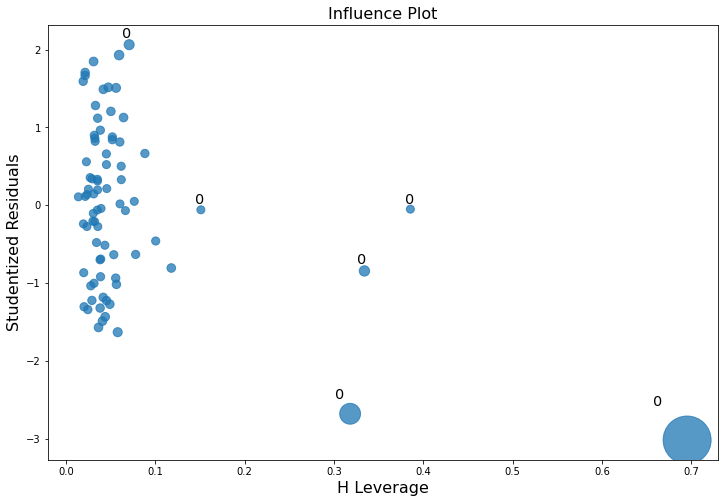

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sma.graphics.influence_plot(modelforout, ax=ax, criterion="cooks")

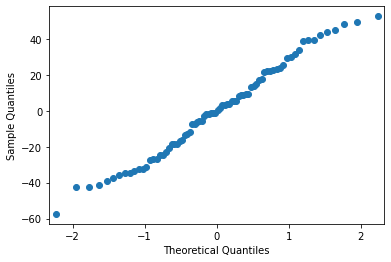

In [43]:
res = model.resid # residuals
fig = sma.qqplot(res)
plt.show()

In [45]:
term = input("search: ")
rank(term)
# India

RESULT 1 : CARGILL CONFIRMS WHITE SUGAR SALE TO INDIA
  Londonbased trader Cargill UK Ltd
  confirmed it sold o ...
RESULT 2 : INDIA FOODGRAIN TARGET 160 MLN TONNES IN 198788
  Indias national foodgrain target has
  been fixed  ...
RESULT 3 : INDIA OILSEED OUTPUT FORECAST TO RISE
  Indias oilseed output is expected to
  rise to 1225 mln tonn ...


In [47]:
# To rework

# term = input("search: ")
# try:
#     result = rank(term)
#     result
#     feedback = input("were these articles helpful?, (Y/N): ")
#     if feedback == "Y":
#         np.save('correct_search.npy', worddic) 
#     else:
#         print("sorry it was not helpful, try again")
# except:
#     print("no results found")

#### Improvments
* BM25
* Bert pretrained tranformers
* Feature extraction
* Vector space